In [23]:
import csv
import glob
import os
import librosa

audio_directory = 'Audios'

data = []

for file in glob.glob(f'{audio_directory}/*.wav'):
    filename = os.path.basename(file)
    label = None
    if "dog" in filename:
        label = "dog"
    elif "cat" in filename:
        label = "cat"
    elif "Human" in filename:
        label = "human"

    if label is not None:
        audio, sr = librosa.load(file, sr=None)
        duration = librosa.get_duration(y=audio, sr=sr)
        formatted_duration = "{:.2f}".format(duration)
        data.append([filename, label, formatted_duration])

csv_filename = "audio_labels_length.csv"

with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = ['fname', 'label', 'length']
    writer = csv.writer(csvfile)
    
    writer.writerow(fieldnames)
    
    for row in data:
        writer.writerow(row)

print(f"CSV file '{csv_filename}' has been created with audio file names, labels, and lengths formatted to two decimal points.")


CSV file 'audio_labels_length.csv' has been created with audio file names, labels, and lengths formatted to two decimal points.


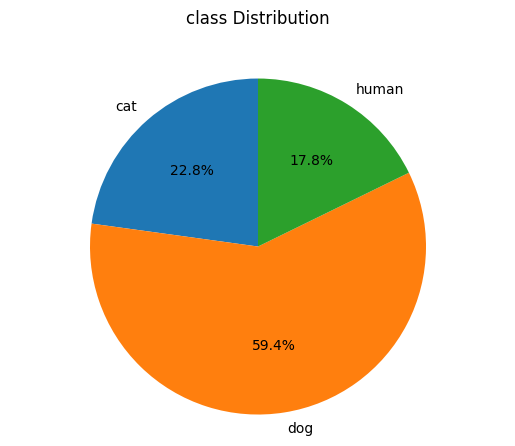

100%|██████████| 1862/1862 [00:07<00:00, 249.89it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 13, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 13, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 13, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 6, 128)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 9, 6, 128)         0         
                                                        

INFO:tensorflow:Assets written to: models\conv.model\assets


53/53 [==============================] - 8s 114ms/step - loss: 0.7878 - acc: 0.6704 - val_loss: 0.4003 - val_acc: 0.8289
Epoch 2/10
52/53 [============================>.] - ETA: 0s - loss: 0.2177 - acc: 0.9189
Epoch 2: val_acc improved from 0.82888 to 0.99465, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


53/53 [==============================] - 5s 95ms/step - loss: 0.2163 - acc: 0.9194 - val_loss: 0.0133 - val_acc: 0.9947
Epoch 3/10
52/53 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9964
Epoch 3: val_acc improved from 0.99465 to 1.00000, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


53/53 [==============================] - 5s 102ms/step - loss: 0.0107 - acc: 0.9964 - val_loss: 8.5373e-04 - val_acc: 1.0000
Epoch 4/10
52/53 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9970
Epoch 4: val_acc did not improve from 1.00000
53/53 [==============================] - 4s 67ms/step - loss: 0.0103 - acc: 0.9970 - val_loss: 0.0108 - val_acc: 0.9947
Epoch 5/10
52/53 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9994
Epoch 5: val_acc did not improve from 1.00000
53/53 [==============================] - 4s 66ms/step - loss: 0.0027 - acc: 0.9994 - val_loss: 1.8519e-04 - val_acc: 1.0000
Epoch 6/10
52/53 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9994
Epoch 6: val_acc did not improve from 1.00000
53/53 [==============================] - 3s 63ms/step - loss: 0.0013 - acc: 0.9994 - val_loss: 2.2239e-05 - val_acc: 1.0000
Epoch 7/10
52/53 [============================>.] - ETA: 0s - loss: 9.2265e-04 - acc: 0.9994
Epoch 7: 

INFO:tensorflow:Assets written to: models\conv.model\assets


In [6]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from keras.layers import Conv2D, MaxPool2D,Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config
import librosa
import warnings

# Filter out the specific warning message
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(3,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    return model

def get_recurrent_model():
    #shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128,return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(3,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    return model

def check_data():
    if os.path.isfile(config.p_path) :
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path,'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    max_shape = (13,0)
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(df[df.label == rand_class].index)
        rate,wav = wavfile.read('Audios/'+file)
        # z, rate = librosa.load('Audios/'+ file, sr=None)
        # D = librosa.stft(z, n_fft=2500)  # Adjust the 'n_fft' parameter as needed
        # wav = librosa.istft(D)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample =  mfcc(sample, rate, numcep=config.nfeat, nfilt = config.nfilt,nfft=config.nfft)
        _min = min(np.amin(X_sample),_min)
        _max = max(np.amax(X_sample),_max)
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label))
        max_shape = (max(X_sample.shape[0], max_shape[0]), max(X_sample.shape[1], max_shape[1]))

    padded_X = []
    for x_sample in X:
        pad_width = ((0, max_shape[0] - x_sample.shape[0]), (0, max_shape[1] - x_sample.shape[1]))
        padded_X.append(np.pad(x_sample, pad_width, mode='constant', constant_values=0))
    X = padded_X
    config.min = _min
    config.max = _max
    # print(np.array(X))
    X,y = np.array(X), np.array(y)
    X = (X - _min)/ (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2])
    y = to_categorical(y,num_classes=3)
    # config.data = (X, y)
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
    return X,y



df = pd.read_csv('f:/Major-I/audio_labels_length.csv') # adding csv
df.set_index('fname',inplace= True)

for f in df.index:
    rate,signal = wavfile.read('Audios/'+f)
    df.at[f,'length'] = signal.shape[0]/rate


classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p = prob_dist)

fig, ax = plt.subplots()
ax.set_title('class Distribution',y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()

config = Config(mode = 'conv')


if config.mode == 'conv':
    X,y = build_rand_feat()
    y_flat = np.argmax(y,axis=1)
    input_shape = (X.shape[1], X.shape[2],1)
    model = get_conv_model()


elif config.mode == 'time':
    X,y = build_rand_feat()
    y_flat = np.argmax(y,axis=1)
    input_shape = (X.shape[1], X.shape[2],1)
    model = get_recurrent_model()

class_weight = compute_class_weight('balanced', classes = np.unique(y_flat),y = y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor= 'val_acc' ,verbose=1, mode= 'max',
                             save_best_only=True, save_weights_on1y=False,period = 1)


model.fit(X,y,epochs=10,batch_size=32,shuffle=True,
          validation_split = 0.1,
          callbacks = [checkpoint])
model.save(config.model_path)




(3,)

In [1]:
from pydub import AudioSegment
import os

# Specify the directory containing your AIFF files and where you want to save the WAV files
input_directory = 'wavfile'
output_directory = 'N_wavfile'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate through the files in the input directory
for filename in os.listdir(input_directory):
    if filename.lower().endswith(('.aif', '.aiff')):
        # Construct the full paths for the input and output files
        input_aiff_file = os.path.join(input_directory, filename)
        output_wav_file = os.path.join(output_directory, os.path.splitext(filename)[0] + ".wav")

        # Load the AIFF file using PyDub
        audio = AudioSegment.from_file(input_aiff_file, format="aiff")

        # Export the audio as a WAV file
        audio.export(output_wav_file, format="wav")

        print(f"Converted: {filename}")

print("AIFF to WAV conversion complete.")

AIFF to WAV conversion complete.


c:\Users\aelis\.conda\envs\audio_lib\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [6]:
import os
import wave

def find_unsupported_wav_files(directory):
    unsupported_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            try:
                with wave.open(file_path, 'rb') as wav_file:
                    # Check the format
                    if wav_file.readframes(1):
                        format_str = wav_file.readframes(1)
                        if format_str not in [b'RIFF', b'RIFX']:
                            unsupported_files.append(file_path)
            except wave.Error as e:
                print(f"Error processing {filename}: {e}")

    return unsupported_files

# Replace 'your_directory_path' with the actual path to your 'wavfile' directory
directory_path = './Audios/Human'
unsupported_files = find_unsupported_wav_files(directory_path)
print("file size is ", len(unsupported_files))

if unsupported_files:
    print("Unsupported files:")
    for file_path in unsupported_files:
        print(file_path)
else:
    print("All .wav files have supported formats.")


file size is  799
Unsupported files:
./Audios/Human\Human(1).wav
./Audios/Human\Human(10).wav
./Audios/Human\Human(100).wav
./Audios/Human\Human(101).wav
./Audios/Human\Human(102).wav
./Audios/Human\Human(103).wav
./Audios/Human\Human(104).wav
./Audios/Human\Human(105).wav
./Audios/Human\Human(106).wav
./Audios/Human\Human(107).wav
./Audios/Human\Human(108).wav
./Audios/Human\Human(109).wav
./Audios/Human\Human(11).wav
./Audios/Human\Human(110).wav
./Audios/Human\Human(111).wav
./Audios/Human\Human(112).wav
./Audios/Human\Human(113).wav
./Audios/Human\Human(114).wav
./Audios/Human\Human(115).wav
./Audios/Human\Human(116).wav
./Audios/Human\Human(117).wav
./Audios/Human\Human(118).wav
./Audios/Human\Human(119).wav
./Audios/Human\Human(12).wav
./Audios/Human\Human(120).wav
./Audios/Human\Human(121).wav
./Audios/Human\Human(122).wav
./Audios/Human\Human(123).wav
./Audios/Human\Human(124).wav
./Audios/Human\Human(125).wav
./Audios/Human\Human(126).wav
./Audios/Human\Human(127).wav
./Audios

In [5]:
from pydub import AudioSegment
import os

def check_wav_format(file_path):
    with open(file_path, 'rb') as file:
        header = file.read(4)
        return header not in {b'RIFF', b'RIFX'}

def convert_to_standard_wav(file_path):
    audio = AudioSegment.from_wav(file_path)
    # Export the audio with standard 'RIFF' header
    audio.export(file_path, format="wav")

def convert_unsupported_wav_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            if check_wav_format(file_path):
                print(f"Converting {file_path} to standard WAV format...")
                convert_to_standard_wav(file_path)

# Replace 'your_directory' with the path to your 'wavfile' directory
directory = './Audios/Human/'

convert_unsupported_wav_files(directory)
